In [10]:
import pandas as  pd
import numpy as np
import warnings 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
from scipy import stats
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
import torch

In [11]:
dataset = pd.read_csv('date_label.csv')

In [12]:
dataset_purchase = pd.read_csv('date_label.csv', usecols=[2], engine='python')
dataset_redeem = pd.read_csv('date_label.csv', usecols=[3], engine='python')

In [13]:
    def create_data_set(data_set):
        data_x, data_y = [], []
        for i in range(len(data_set)-40 - 30):
            a = data_set[i:(i + 40), 0]
            data_x.append(a)
            data_y.append(list(data_set[i + 40: i + 40 + 30, 0]))
        # print(numpy.array(data_y).shape)
        return np.array(data_x), np.array(data_y), data_set[-40:, 0].reshape(1, 1, 40)

In [14]:
   def access_data(data_frame):
        # load the data set
        data_set = data_frame.values
        data_set = data_set.astype('float32')

        # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_set = scaler.fit_transform(data_set)

        # reshape into X=t and Y=t+1
        train_x, train_y, test = create_data_set(data_set)

        # reshape input to be [samples, time steps, features]
        train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
        return train_x, train_y, test, scaler

In [15]:
from sklearn.preprocessing import MinMaxScaler
purchase_train_x, purchase_train_y, purchase_test, purchase_scaler = access_data(dataset_purchase)
redeem_train_x, redeem_train_y, redeem_test,redeem_scaler = access_data(dataset_redeem)
redeem_train_x

array([[[0.00716242, 0.0017188 , 0.00794832, ..., 0.05148092,
         0.05119317, 0.05225483]],

       [[0.0017188 , 0.00794832, 0.00878555, ..., 0.05119317,
         0.05225483, 0.04581037]],

       [[0.00794832, 0.00878555, 0.00210188, ..., 0.05225483,
         0.04581037, 0.02520903]],

       ...,

       [[0.5222233 , 0.42036986, 0.65912163, ..., 0.30236444,
         0.63108546, 0.55318844]],

       [[0.42036986, 0.65912163, 0.6820178 , ..., 0.63108546,
         0.55318844, 0.45539764]],

       [[0.65912163, 0.6820178 , 0.782245  , ..., 0.55318844,
         0.45539764, 0.50501776]]], dtype=float32)

In [16]:
batch_size=16
epochs_purchase=150 
epochs_redeem=230
torch_train_purchase = Data.TensorDataset(torch.Tensor(purchase_train_x), torch.Tensor(purchase_train_y))
purchase_train_loader = Data.DataLoader(
    dataset=torch_train_purchase,  # torch TensorDataset format
    batch_size=16,  # mini batch size
    shuffle=False,  # 要不要打乱数据 (打乱比较好)
    num_workers=2,  # 多线程来读数据
)

torch_train_redeem = Data.TensorDataset(torch.Tensor(redeem_train_x), torch.Tensor(redeem_train_y))
redeem_train_loader = Data.DataLoader(
    dataset=torch_train_redeem,
    batch_size=16,  # mini batch size
    shuffle=False,  # 要不要打乱数据 (打乱比较好)
    num_workers=2,  # 多线程来读数据
)

In [17]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
#         input (batch_size, 1, 1)
        self.rnn1 = nn.LSTM(  # if use nn.RNN(), it hardly learns
            input_size=40,
            hidden_size=64,  # rnn hidden unit
            num_layers=1,  # number of rnn layer
            batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.rnn2 = nn.LSTM(
            input_size=64,
            hidden_size=32, 
            num_layers=1,
            batch_first=True,
            )
        self.linear = nn.Linear(32, 32)
        self.out = nn.Linear(32, 30)

    def forward(self, x):
#         print(x.size())
        r1_out, (h_n1, h_c1) = self.rnn1(x, None)
#         print(r1_out.size())
        r2_out, (h_n2, h_c2) = self.rnn2(r1_out, None)
        linear_out = self.linear(r2_out[:, -1, :])
        out = self.out(linear_out)
        return out
    
model = RNN()
model_r = RNN()
print(model)
import torch.optim as optim
# 定义优化器
optimizer = optim.Adam(model.parameters())
loss_func = nn.MSELoss()
# torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

# optimizer_r = optim.Adam(model_r.parameters())
# loss_func_r = nn.MSELoss()

from sklearn.metrics import mean_squared_error

RNN(
  (rnn1): LSTM(40, 64, batch_first=True)
  (rnn2): LSTM(64, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=30, bias=True)
)


In [18]:
best_loss_p = float('inf')
for epoch in range(501):
    for step, (batch_x, batch_y) in enumerate(purchase_train_loader):
        output = model(batch_x)
#         print('output:',output.size(),'batch_y:',batch_y.size())
        loss = loss_func(output, batch_y)  # cross entropy loss

        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()
        mse = mean_squared_error(batch_y.numpy().tolist(), output.detach().numpy())
        if loss.detach().numpy() < best_loss_p:
            best_loss_p = loss.detach().numpy()
            torch.save(model.state_dict(), 'stock-lstm-p-model.pt')
            
    if epoch % 50 == 0:
        print('epoch: ', epoch, '| loss: ', loss.detach().numpy(), '| mse: ', mse)

print('----------------------')
best_loss_r = float('inf')
for epoch in range(501):
    for step, (batch_x, batch_y) in enumerate(redeem_train_loader):
        output = model(batch_x)
#         print('output:',output.size(),'batch_y:',batch_y.size())
        loss = loss_func(output, batch_y)  # cross entropy loss

        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()
        mse = mean_squared_error(batch_y.numpy().tolist(), output.detach().numpy())
        if loss.detach().numpy() < best_loss_r:
            best_loss_r = loss.detach().numpy()
            torch.save(model.state_dict(), 'stock-lstm-r-model.pt')
            
    if epoch % 50 == 0:
        print('epoch: ', epoch, '| loss: ', loss.detach().numpy(), '| mse: ', mse)

epoch:  0 | loss:  0.03560239 | mse:  0.03560239086532389
epoch:  50 | loss:  0.004969255 | mse:  0.0049692551106413265
epoch:  100 | loss:  0.0043036775 | mse:  0.004303677519291411
epoch:  150 | loss:  0.004268379 | mse:  0.0042683788209086256
epoch:  200 | loss:  0.004287517 | mse:  0.004287517361132246
epoch:  250 | loss:  0.004160015 | mse:  0.0041600148212425775
epoch:  300 | loss:  0.0034777776 | mse:  0.0034777775945498577
epoch:  350 | loss:  0.0028796766 | mse:  0.0028796765313035236
epoch:  400 | loss:  0.0028950204 | mse:  0.0028950203713124165
epoch:  450 | loss:  0.002625563 | mse:  0.0026255628419819123
epoch:  500 | loss:  0.0024594404 | mse:  0.002459440271410604
----------------------
epoch:  0 | loss:  0.025482737 | mse:  0.025482735880716017
epoch:  50 | loss:  0.007705538 | mse:  0.007705537886599425
epoch:  100 | loss:  0.0065646926 | mse:  0.006564692709733626
epoch:  150 | loss:  0.0054894267 | mse:  0.005489426498333969
epoch:  200 | loss:  0.0053771557 | mse: 

In [19]:
model.load_state_dict(torch.load('stock-lstm-p-model.pt'))
model_r.load_state_dict(torch.load('stock-lstm-r-model.pt'))
pred_purchase = model(torch.Tensor(purchase_test)).detach().numpy()
purchase = purchase_scaler.inverse_transform(pred_purchase)

pred_redeem = model_r(torch.Tensor(redeem_test)).detach().numpy()
redeem = redeem_scaler.inverse_transform(pred_redeem)
np.shape(purchase)

(1, 30)

    report_date     purchase       redeem
0      20140901  303569216.0  326890048.0
1      20140902  333317248.0  263576704.0
2      20140903  330279808.0  263136800.0
3      20140904  280795168.0  258862368.0
4      20140905  226916416.0  270493504.0
5      20140906  206948208.0  197618688.0
6      20140907  242488672.0  169432288.0
7      20140908  303694880.0  332323616.0
8      20140909  332310880.0  318817536.0
9      20140910  312490560.0  364077376.0
10     20140911  258215440.0  360447552.0
11     20140912  207631024.0  363669120.0
12     20140913  200364288.0  278055648.0
13     20140914  243133472.0  267004608.0
14     20140915  305481184.0  394079296.0
15     20140916  335481792.0  367010336.0
16     20140917  327982464.0  356311328.0
17     20140918  277513568.0  286828832.0
18     20140919  229964048.0  284435968.0
19     20140920  217208608.0  217241088.0
20     20140921  255285520.0  194224112.0
21     20140922  317112608.0  316206496.0
22     20140923  345486688.0  3369

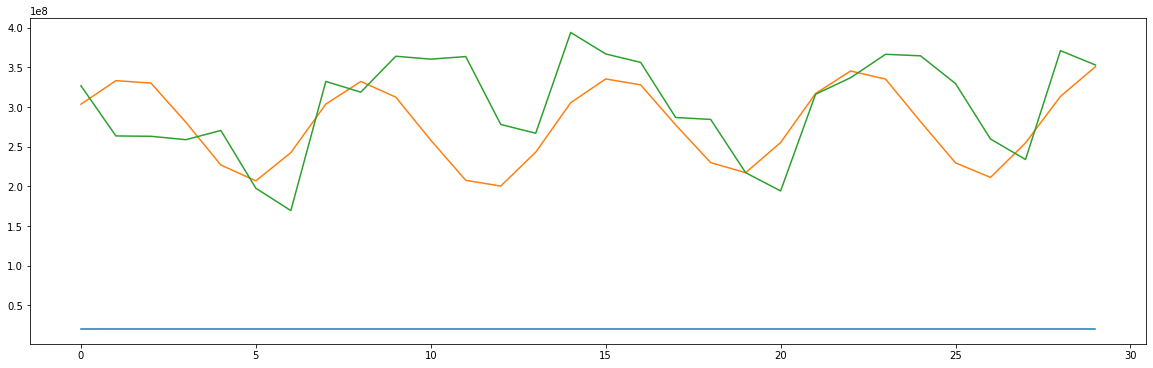

In [20]:
import matplotlib.pyplot as plt
test_user = pd.DataFrame({'report_date': [20140900 + i for i in range(1, 31)]})
np.shape(test_user)
test_user['purchase'] = purchase.reshape(30, 1)
test_user['redeem'] = redeem.reshape(30, 1)
print(test_user)
plt.figure(figsize=(20,6))
plt.plot(test_user)
plt.show()

In [ ]:
test_user.to_csv('submit_lstm.csv', encoding='utf-8', index=None, header=None)